In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from random import random, randrange, choice, shuffle
from datetime import datetime, timedelta, date
from itertools import combinations
from pprint import pprint
import calendar
import plotly.express as px
import time

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" # Cell의 모든 반환값 출력

pd.set_option('display.max_rows', None)

import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# 함수 정의

## 블록데이터 전처리 함수

In [2]:
import functools
def unpack_df_columns(func):
    @functools.wraps(func)
    def _unpack_df_columns(*args, **kwargs):
        series = args[0]
        return func(*series.values)
    return _unpack_df_columns

@unpack_df_columns
def 최소착수요구일구하기(납기, 공기):
    result = pd.to_datetime(납기) - timedelta(days=int(공기))
    return result.date()

@unpack_df_columns
def 블록우선순위구하기(날짜순서, 공기순서, 크기순서):
    global 착수일가중치, 공기가중치, 크기가중치
    result = np.round((날짜순서*float(착수일가중치) + 공기순서*float(공기가중치) + 크기순서*float(크기가중치))/3,1)
    return result

@unpack_df_columns
def 블록사이즈튜플만들기(가로, 세로):
    길이2 = max(가로, 세로)  
    길이1 = min(가로, 세로)
    result = (길이2, 길이1)
    return result

def 블록데이터전처리(블록원데이터):
    df1 = 블록원데이터.copy()
    df1["blk_id"] = df1["블록명"].apply(lambda x: x[1:])
    df1["사이즈"] = df1[["가로", "세로"]].apply(블록사이즈튜플만들기, axis=1)
    df1["최대길이"] = df1["사이즈"].apply(lambda x: max(x))
    df1["납기"] = pd.to_datetime(df1["납기"])
    df1["면적"] = df1.eval("가로*세로")
    df1["최소착수요구일"] = df1[["납기", "표준공기"]].apply(최소착수요구일구하기, axis=1)
    df1["날짜순서"] = df1["최소착수요구일"].rank()
    df1["공기순서"] = df1["표준공기"].rank(ascending=False)
    df1["크기순서"] = df1["면적"].rank(ascending=False)
    df1["우선순위"] = df1[["날짜순서", "공기순서", "크기순서"]].apply(블록우선순위구하기, axis=1)
    
    df1 = df1.drop(['가로', '세로'], axis=1)
    df1 = df1.sort_values(by=["우선순위"])
    return df1

## 정반데이터 전처리 함수

In [3]:
@unpack_df_columns
def 정반우선순위구하기(중순, 크순):
    global 중량가중치, 크기가중치
    result = np.round((중순*float(중량가중치) + 크순*float(크기가중치))/3,1)
    return result

@unpack_df_columns
def 정반사이즈튜플만들기(가로, 세로):
    길이1 = max(가로, 세로)  
    길이2 = min(가로, 세로)
    result = (길이1, 길이2)
    return result

def 정반데이터전처리(정반원데이터):
    df = 정반원데이터.copy()
    
    df["사이즈"] = df[["가로", "세로"]].apply(정반사이즈튜플만들기, axis=1)
    df["면적"] = df.eval("가로*세로")
    df["최대길이"] = df["사이즈"].apply(lambda x: max(x))
    df["중량순서"] = df["가능중량"].rank(ascending=False)
    df["크기순서"] = df["면적"].rank(ascending=False)
    df["우선순위"] = df[["중량순서", "크기순서"]].apply(정반우선순위구하기, axis=1)
    
    df = df.drop(['가로', '세로'], axis=1)
    df = df.sort_values(by=["우선순위"])
    return df

## 물리조건 체크 함수 (중량, 최장길이)

In [4]:
def 중량조건체크(target_block):
    가능정반리스트 = []
    블록중량 = 블록데이터[블록데이터["블록명"]==target_block]["중량"].values[0]
    for 정반 in 정반데이터["정반명"]:
        정반가능중량 = 정반데이터[정반데이터["정반명"]==정반]["가능중량"].values[0]
        if 정반가능중량 > 블록중량:
            가능정반리스트.append(정반)       
    return 가능정반리스트  

def 최장길이체크(target_block:str, 중량가능정반들:list):
    가능정반리스트 = []
    블록최장길이 = 블록데이터[블록데이터["블록명"]==target_block]["최대길이"].values[0]
    for 정반 in 중량가능정반들:
        정반최장길이 = 정반데이터[정반데이터["정반명"]==정반]["가능중량"].values[0]
        if 정반최장길이 > 블록최장길이:
            가능정반리스트.append(정반)
    return 가능정반리스트

## 레이아웃 함수

In [5]:
def init_jungban(사이즈):  #사이즈 = (10, 10)
    surface_width, surface_height = 사이즈[0], 사이즈[1]  # Adjusted to match the provided image for demonstration
    surface = np.zeros((surface_height, surface_width), dtype=int)
    return surface, surface_width, surface_height

def can_place_with_thresh(surface, surface_width, surface_height, block_height, block_width, start_row, start_col, thresh):
    new_width = surface_width - thresh
    new_height = surface_height - thresh
    
    if start_row + block_height > surface_height or start_col + block_width > surface_width:
        return False

    block_area = surface[start_row:start_row+block_height, start_col:start_col+block_width]
    if np.any(block_area != 0):
        return False
    
    if start_row > 0 and np.any(surface[start_row-thresh: start_row, start_col:start_col+block_width] != 0):
        return False
    if start_col > 0 and np.any(surface[start_row: start_row+block_height, start_col-thresh: start_col] != 0):
        return False
    
    return True

# Function to place a block on the surface, if possible
def place_block(surface, block_height, block_width, start_row, start_col, block_id):
    block_height, block_width = block_height, block_width
    surface[start_row:start_row + block_height, start_col:start_col + block_width] = block_id
    return surface


# def 레이아웃배치(surface, surface_width, surface_height, block_width, block_height, block_id, thresh):
def 레이아웃배치(surface, surface_width, surface_height, block_height, block_width, block_id, thresh):

    best_fit_score = float('inf')
    best_position = None
    
    for start_row in range(surface_height - block_height + 1):
        for start_col in range(surface_width - block_width + 1):
            if can_place_with_thresh(surface, surface_width, surface_height, block_height, block_width, start_row, start_col, thresh):
                # Calculate a score; here we use the top-left corner (y, x) as the score
                # A lower score means the block is closer to the top-left
                score = start_row + start_col
                if score < best_fit_score:
                    best_fit_score = score
                    best_position = (start_row, start_col)
    
    if best_position:
        surface = place_block(surface, block_height, block_width, *best_position, block_id)
        return True, surface
    else:
        return False, surface

def get_overlapped_surface(*arrays):
    result = arrays[0]
    for arr in arrays[1:]:
        result = np.add(result, arr)
    return result

# 특정 값만 남기고 다 지운후에 그 결과를 다시 각 해당일 surface에 더해준다...천재네..ㅋ
def extract_newblock_layout_only(overlapped_surface, block_id):
    mask = overlapped_surface != block_id
    overlapped_surface[mask] = 0
    newblock_layout = overlapped_surface
    return newblock_layout

In [6]:
def draw_layout(레이아웃달력, 정반, idx):
    target_date = 레이아웃달력.index[idx]
    target_surface = 레이아웃달력.at[target_date, 정반]
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.imshow(target_surface, cmap="Blues", interpolation='nearest')
    
    for i in range(len(target_surface)):
        for j in range(len(target_surface[0])):
            plt.text(j, i, f'{target_surface[i, j]}', ha='center', va='center', color='white', fontsize=7)
    # plt.colorbar()  # Add a color bar to show the mapping of values to colors
    plt.show()


## 레이아웃 달력

In [7]:
def get_end_date_of_month(year, month):
    # Get the number of days in the given month
    num_days = calendar.monthrange(year, month)[1]
    # Return the last day of the month as a datetime object
    return date(year, month, num_days)

def create_레이아웃달력(시작년:int, 시작월:int, 시작일: int, 종료년:int, 종료월:int, 정반데이터:pd.DataFrame) -> pd.DataFrame:
    start_date = datetime(시작년, 시작월, 시작일)
    end_date = get_end_date_of_month(종료년, 종료월)
    정반집합 = 정반데이터["정반명"].tolist()
    날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
    
    달력 = pd.DataFrame()
    달력.index = 날짜집합
    
    for 정반 in 정반집합:
        정반사이즈 = 정반데이터[정반데이터["정반명"]==정반]["사이즈"].values[0]
        # print(f"{정반}정반사이즈: {정반사이즈}")
        surface, surface_width, surface_height = init_jungban(정반사이즈)
        달력[정반] = [surface for _ in range(len(날짜집합))]
        
    return 달력

In [8]:
def update_레이아웃달력(레이아웃달력, 정반명, 블록명, 정반데이터, 블록데이터):
    # 변수정리
    조기착수금지일 = 10
    thresh = 1
    최소착수요구일 = 블록데이터[블록데이터["블록명"]==블록명]["최소착수요구일"].values[0]
    표준공기 = int(블록데이터[블록데이터["블록명"]==블록명]["표준공기"].values[0])
    blk_id = 블록데이터[블록데이터["블록명"]==블록명]["blk_id"].values[0]
    블록사이즈 = 블록데이터[블록데이터["블록명"]==블록명]["사이즈"].values[0]
    정반사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    surface_width, surface_height = 정반사이즈[0], 정반사이즈[1]
    block_width, block_height = 블록사이즈[0], 블록사이즈[1]
    
    날짜리스트 = [d.strftime("%Y-%m-%d") for d in 레이아웃달력.index]
    start_date = 최소착수요구일 # datetime.strptime(최소착수요구일, "%Y-%m-%d").date()
    min_start_date = start_date - timedelta(days=조기착수금지일)
    
    end_date = min_start_date + timedelta(days=표준공기)
    min_start_date= min_start_date.strftime('%Y-%m-%d')
    end_date = end_date.strftime('%Y-%m-%d')
    min_start_idx = 날짜리스트.index(min_start_date)
    end_idx = 날짜리스트.index(end_date)
    
    # 레이아웃 순환 검토 
    # 후퇴배수 = int(표준공기 * 1)   # 최선조기착수일 인덱스에서 표준공기의 최대 00배수까지 후퇴 검토
    후퇴배수 = 14 # 그냥 숫자로 한정하기
    for k in range(후퇴배수):  
        min_start_idx += 1
        end_idx += 1
        print(f">>>>> 검토차수{k} / {레이아웃달력.index[min_start_idx]}: {min_start_idx} ~ {end_idx}")
    
        target_surfaces = []
        temp_dates = []
        for idx in range(min_start_idx, end_idx+1): # 표준공기에 해당하는 시기인덱스~종기인덱스 순환 검토
            target_date = 레이아웃달력.index[idx]    # 대상인덱스의 날짜 불러오기
            temp_dates.append(target_date)
            target_surface = 레이아웃달력.at[target_date, 정반명]  # 조회날짜의 레이아웃(서페이스) 불러오기
            target_surfaces.append(target_surface)   # 조회날짜의 레이아웃들을 리스트로 담기
                
        overlapped_surface = get_overlapped_surface(*target_surfaces)  # 리스트에 담은 레이아웃을 합하여 오버랩 레이아웃 생성
        
        bool_res, surface = 레이아웃배치(overlapped_surface, surface_width, surface_height, block_width, block_height, blk_id, thresh)  # 오버랩 레이아웃에 신규 블록 레이아웃 배치검토
        
        if bool_res:  # 신규블록이 배치되어 True라면...
            newblock_layout = extract_newblock_layout_only(surface, int(blk_id))  # 신규배치블록의 레이아웃만 추출 (기배치 다른 블록 레이아웃 제거)
            
            for idx in range(min_start_idx, end_idx+1):   # 조회기간 다시 탐색 (레이아웃 업데이트를 위해)
                target_date = 레이아웃달력.index[idx]  
                target_surface = 레이아웃달력.at[target_date, 정반명]    # 조회일의 레이아웃 불러오기
                target_surface = target_surface + newblock_layout        # 조회일의 레이아웃에 새블록 레이아웃 더하여 내용 합치기
                레이아웃달력.at[target_date, 정반명] = target_surface   # 해당일의 레이아웃을 새레이아웃으로 변경하기 (업데이트 완료)
            
            최선배치일 = temp_dates[0].strftime('%Y-%m-%d')
            최선정반 = 정반명
            break

        else:
            # 가로세로 바꿔서
            bool_res, surface = 레이아웃배치(overlapped_surface, surface_width, surface_height, block_width, block_height, blk_id, thresh)  

            if bool_res:
                newblock_layout = extract_newblock_layout_only(surface, int(blk_id))  # 신규배치블록의 레이아웃만 추출 (기배치 다른 블록 레이아웃 제거)
            
                for idx in range(min_start_idx, end_idx+1):   # 조회기간 다시 탐색 (레이아웃 업데이트를 위해)
                    target_date = 레이아웃달력.index[idx]  
                    target_surface = 레이아웃달력.at[target_date, 정반명]    # 조회일의 레이아웃 불러오기
                    target_surface = target_surface + newblock_layout        # 조회일의 레이아웃에 새블록 레이아웃 더하여 내용 합치기
                    레이아웃달력.at[target_date, 정반명] = target_surface   # 해당일의 레이아웃을 새레이아웃으로 변경하기 (업데이트 완료)
            
                최선배치일 = temp_dates[0].strftime('%Y-%m-%d')
                최선정반 = 정반명
                break

            else:  # 신규블록 배치가 False라면.. 계속 순환
                최선배치일 = None
                최선정반 = None
        
        
    return 레이아웃달력, 최선정반, 최선배치일

In [9]:
# 레이아웃달력 = create_레이아웃달력(2024, 2, 1, 2024, 4, 정반데이터)
# 대상정반 = "A"
# 정반사이즈 = (42, 28)
# 최소착수요구일 = "2024-02-10"
# 조기착수금지일 = 7
# 표준공기 = 3
# 레이아웃달력 = 레이아웃달력
# 블록사이즈 = (20, 20)
# blk_id = 1
# thresh = 1 # 블록최소간격

# surface_width, surface_height = 정반사이즈[0], 정반사이즈[1]
# block_width, block_height = 블록사이즈[0], 블록사이즈[1]

# 날짜리스트 = [d.strftime("%Y-%m-%d") for d in 레이아웃달력.index]
# start_date = datetime.strptime(최소착수요구일, "%Y-%m-%d").date()
# min_start_date = start_date - timedelta(days=조기착수금지일)

# end_date = min_start_date + timedelta(days=표준공기)
# min_start_date= min_start_date.strftime('%Y-%m-%d')
# end_date = end_date.strftime('%Y-%m-%d')
# min_start_idx = 날짜리스트.index(min_start_date)
# end_idx = 날짜리스트.index(end_date)
# min_start_date, min_start_idx, end_idx

In [10]:
# for k in range(표준공기*3):
#     min_start_idx += k
#     end_idx += k
#     print(f">>> 검토차수{k}: {min_start_idx} ~ {end_idx}")

#     target_surfaces = []
#     temp_dates = []
#     for idx in range(min_start_idx, end_idx+1):
#         target_date = 레이아웃달력.index[idx]
#         temp_dates.append(target_date)
#         target_surface = 레이아웃달력.at[target_date, 대상정반]
#         target_surfaces.append(target_surface)

#     overlapped_surface = get_overlapped_surface(*target_surfaces)
#     bool_res, surface = 레이아웃배치(overlapped_surface, surface_width, surface_height, block_width, block_height, blk_id, thresh)
    
#     if bool_res:
#         print(">>> 조회기간 레이아웃 배치가능")
#         newblock_layout = extract_newblock_layout_only(surface, blk_id)

#         for idx in range(min_start_idx, end_idx+1):
#             target_date = 레이아웃달력.index[idx]
#             target_surface = 레이아웃달력.at[target_date, 대상정반]
#             target_surface = target_surface + newblock_layout
#             레이아웃달력.at[target_date, 대상정반] = target_surface
#             print(idx, len(target_surface))      
#         break
#     else:
#         print(">>> 다음차수검토")
# 레이아웃달력.head(8)

# 시뮬레이션

In [11]:
data_num = "_실행계획"
블록원데이터 = pd.read_excel(f"D:/공정최적화/data/data1{data_num}.xlsx", sheet_name="블록데이터")
기배치블록 = pd.read_excel(f"D:/공정최적화/data/data1{data_num}.xlsx", sheet_name="기배치블록")
기배치블록.rename(columns={'공기':'표준공기'}, inplace=True)
기배치블록["blk_id"] = 기배치블록["블록명"].apply(lambda x: x[1:])
정반원데이터 = pd.read_excel(f"D:/공정최적화/data/data1{data_num}.xlsx", sheet_name="정반데이터")

기배치블록1 =기배치블록[["블록명", "중량", "가로", "세로", "표준공기", "종료일"]]
기배치블록1.rename(columns={'종료일':'납기'}, inplace=True)
블록마스터 = pd.concat([기배치블록1, 블록원데이터])

검토개수 = 115
블록원데이터 = 블록원데이터.iloc[:검토개수,:]
블록원데이터.shape

착수일가중치, 공기가중치, 크기가중치 = 10, 1, 0.1
블록데이터 = 블록데이터전처리(블록원데이터)

중량가중치, 크기가중치 = 0.5, 0.5
정반데이터 = 정반데이터전처리(정반원데이터)
블록마스터.shape, 기배치블록.shape, 블록데이터.shape, 정반데이터.shape

(115, 6)

((135, 6), (12, 9), (115, 13), (2, 8))

In [12]:
시작년, 시작월, 시작일, 종료년, 종료월 = 2023, 10, 1, 2024, 5
레이아웃달력 = create_레이아웃달력(시작년, 시작월, 시작일, 종료년, 종료월, 정반데이터)

블록리스트 = 블록데이터["블록명"].tolist()
정반리스트 = 정반데이터["정반명"].tolist()

배치정반모음 = []
배치일모음 = []

print(블록리스트)
for _ in tqdm(range(len(블록리스트))):
    target_block = 블록리스트[0]
    print()
    print(f"***** 검토대상블록: {target_block} ---------------------------------------------")

    # 물리조건 체크
    가능정반들 = 중량조건체크(target_block)
    가능정반들 = 최장길이체크(target_block, 가능정반들)

    최선정반 = choice(가능정반들)
    print(f">>>>> 물리조건가능정반들: {가능정반들}, 최선정반(현재는 완전 랜덤 선택): {최선정반}")

    레이아웃달력, 최선정반, 최종배치일 = update_레이아웃달력(레이아웃달력, 최선정반, target_block, 정반데이터, 블록데이터)
    배치정반모음.append(최선정반)
    배치일모음.append(최종배치일)
    print(f">>>>> 블록명:{target_block}, 최선정반: {최선정반}, 최종배치일:{최종배치일}")
    블록리스트.remove(target_block)

['S19', 'S16', 'S15', 'S14', 'S24', 'S13', 'S18', 'S17', 'S20', 'S25', 'S33', 'S23', 'S22', 'S21', 'S26', 'S32', 'S27', 'S36', 'S34', 'S35', 'S40', 'S28', 'S30', 'S29', 'S31', 'S45', 'S39', 'S41', 'S38', 'S46', 'S49', 'S37', 'S47', 'S43', 'S44', 'S52', 'S42', 'S50', 'S51', 'S57', 'S48', 'S63', 'S64', 'S55', 'S59', 'S62', 'S67', 'S53', 'S54', 'S56', 'S58', 'S66', 'S65', 'S70', 'S68', 'S69', 'S71', 'S82', 'S81', 'S72', 'S73', 'S60', 'S61', 'S74', 'S75', 'S76', 'S83', 'S77', 'S86', 'S78', 'S84', 'S80', 'S94', 'S90', 'S79', 'S97', 'S85', 'S87', 'S96', 'S89', 'S99', 'S105', 'S88', 'S103', 'S98', 'S91', 'S92', 'S102', 'S104', 'S93', 'S95', 'S108', 'S112', 'S109', 'S107', 'S111', 'S106', 'S100', 'S101', 'S113', 'S110', 'S116', 'S115', 'S119', 'S114', 'S126', 'S127', 'S120', 'S124', 'S118', 'S121', 'S117', 'S125', 'S122', 'S123']


  0%|          | 0/115 [00:00<?, ?it/s]


***** 검토대상블록: S19 ---------------------------------------------
>>>>> 물리조건가능정반들: ['B', 'A'], 최선정반(현재는 완전 랜덤 선택): A
>>>>> 검토차수0 / 2023-10-25 00:00:00: 24 ~ 36
>>>>> 블록명:S19, 최선정반: A, 최종배치일:2023-10-25

***** 검토대상블록: S16 ---------------------------------------------
>>>>> 물리조건가능정반들: ['B', 'A'], 최선정반(현재는 완전 랜덤 선택): A
>>>>> 검토차수0 / 2023-10-25 00:00:00: 24 ~ 35
>>>>> 블록명:S16, 최선정반: A, 최종배치일:2023-10-25

***** 검토대상블록: S15 ---------------------------------------------
>>>>> 물리조건가능정반들: ['B', 'A'], 최선정반(현재는 완전 랜덤 선택): B
>>>>> 검토차수0 / 2023-10-25 00:00:00: 24 ~ 34
>>>>> 블록명:S15, 최선정반: B, 최종배치일:2023-10-25

***** 검토대상블록: S14 ---------------------------------------------
>>>>> 물리조건가능정반들: ['B', 'A'], 최선정반(현재는 완전 랜덤 선택): A
>>>>> 검토차수0 / 2023-10-24 00:00:00: 23 ~ 30
>>>>> 블록명:S14, 최선정반: A, 최종배치일:2023-10-24

***** 검토대상블록: S24 ---------------------------------------------
>>>>> 물리조건가능정반들: ['B', 'A'], 최선정반(현재는 완전 랜덤 선택): A
>>>>> 검토차수0 / 2023-10-31 00:00:00: 30 ~ 42
>>>>> 블록명:S24, 최선정반: A, 최종배치일:2023-10-31


In [13]:
배치후데이터 = 블록데이터.copy()
배치후데이터["배치정반"] = 배치정반모음
배치후데이터["착수일자"] = 배치일모음
배치후데이터['최소착수요구일'] = pd.to_datetime(배치후데이터['최소착수요구일'])
배치후데이터['착수일자'] = pd.to_datetime(배치후데이터['착수일자'])
배치후데이터["델타"] = 배치후데이터['착수일자'] - 배치후데이터['최소착수요구일']
배치후데이터["델타"] = 배치후데이터["델타"].dt.days
배치후데이터.to_csv("./results/배치결과.csv", encoding='utf-8-sig')
print(f"*** 미배치개수: {배치후데이터['착수일자'].isnull().sum()}")
# 배치후데이터

*** 미배치개수: 24


In [14]:
배치후데이터["델타"].value_counts().sort_index()

델타
-9.0    30
-8.0     2
-7.0     3
-6.0     4
-5.0     6
-4.0     1
-3.0     8
-2.0     3
-1.0     5
 0.0     9
 1.0     2
 2.0     6
 3.0     6
 4.0     6
Name: count, dtype: int64

2023-10-28 00:00:00


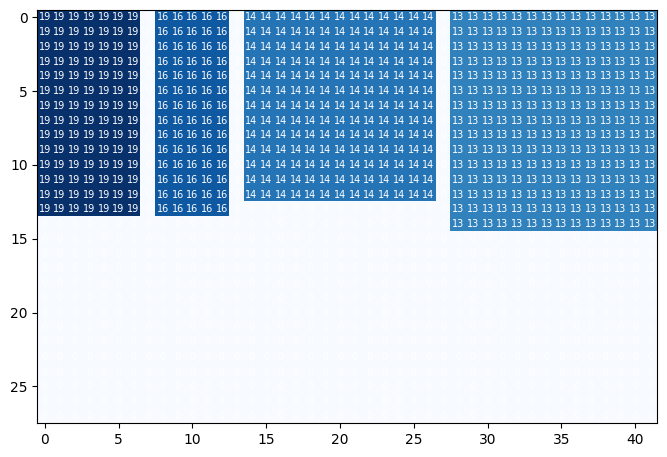

2023-10-29 00:00:00


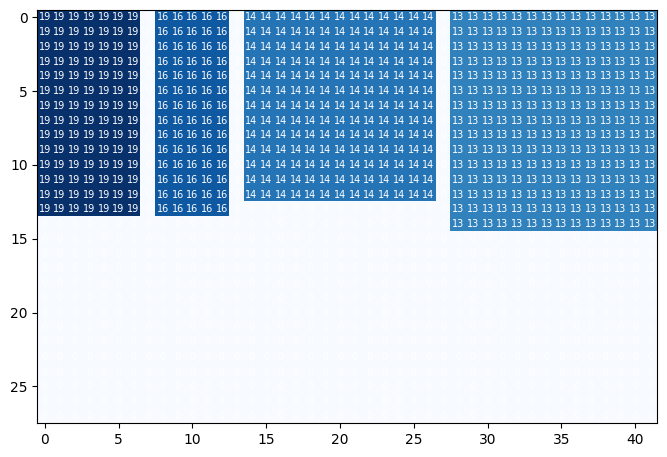

In [15]:
for i in range(27, 29):
    target_date = 레이아웃달력.index[i]
    print(target_date)
    draw_layout(레이아웃달력, "A", i)